# Intracranial Hemorrhage Detection

> The dataset and its description was taken from the competition [RSNA Intracranial Hemorrhage Detection](https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection/) at [Kaggle.com](https://www.kaggle.com) organized by the *Radiological Society of North America* ([RSNA](https://www.rsna.org)).

#### Description & Motivation:

-----------------------------------------------------------------------------
> Intracranial hemorrhage, bleeding that occurs inside the cranium, is a serious health problem requiring rapid and often intensive medical treatment. For example, intracranial hemorrhages account for approximately 10% of strokes in the U.S., where stroke is the fifth-leading cause of death. Identifying the location and type of any hemorrhage present is a critical step in treating the patient.

> Diagnosis requires an urgent procedure. When a patient shows acute neurological symptoms such as severe headache or loss of consciousness, highly trained specialists review medical images of the patient’s cranium to look for the presence, location and type of hemorrhage. The process is complicated and often time consuming.

> Four research institutions provided large volumes of de-identified CT studies that were assembled to create the challenge dataset: Stanford University, Thomas Jefferson University, Unity Health Toronto and Universidade Federal de São Paulo (UNIFESP), The American Society of Neuroradiology (ASNR) organized a cadre of more than 60 volunteers to label over 25,000 exams for the challenge dataset. A full set of acknowledgments can be found on [this page](https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection/overview/acknowledgments)

###  - - - - > Purpose: _Identify acute intracranial hemorrhage and its subtypes_

------------------------------------------------------------------------------
#### Background reading:

> - Heit & Wintermark (2017) Imaging of intracranial hemorrhage. J Stroke 19:11–27 [link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5307932/)
> - Ye et al. "Precise diagnosis of intracranial hemorrhage and subtypes using a three-dimensional joint convolutional and recurrent neural network." European radiology (2019): 1-11. [link](https://link.springer.com/article/10.1007/s00330-019-06163-2)


# Overview / Implementation


Given the problem, we will perform the following steps :

- Image pre-processing using Scikit-Image
- Image classification 1: IntraCranial Hemorrhage (ICH) vs Healthy (no-ICH)
- Image classification 2: Subtypes of IntraCranial Hemorrhage for positive images (ICH)


In [1]:
import os, sys
from graphs.my_graph import graphs # my custom dataviz environment, see github.com/yzerlaut/graphs
mg = graphs('notebook') # initialize a visualization env optimize for notebook display
import numpy as np
import pydicom # pydicom to load CT-scan data
import pandas as pd

# Loading and reformating the data

### ICH Labels for all samples

In [2]:
# building a meaningful pandas dataframe for the problem

def transform_csv_to_dataframe(filename):
    df= pd.read_csv(filename)
    data, LIST_OF_DICT, i = {}, [], 0
    for Id, label in zip(df['ID'], df['Label']):
        id_key, area_key = Id.split('_')[1:]
        if id_key not in data:
            data[id_key] = {'ID':id_key, area_key:np.float(label), 'i':i}
            i+=1
            LIST_OF_DICT.append({'ID':id_key, area_key:np.float(label)})
        else:
            data[id_key][area_key] = np.float(label)
            LIST_OF_DICT[-1][area_key] = np.float(label)
    return pd.DataFrame(LIST_OF_DICT)


In [3]:
DF_train = transform_csv_to_dataframe('data/stage_1_train.csv') # load training data
DF_train[12:16] # showing 4 elements

,ID,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
12,4419f8ae9,0.0,0.0,0.0,0.0,0.0,0.0
13,bcf1add28,0.0,0.0,0.0,0.0,0.0,0.0
14,aeda0804d,1.0,0.0,0.0,0.0,0.0,1.0
15,86efc4c17,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
DF_submission = transform_csv_to_dataframe('data/stage_1_sample_submission.csv') # load test data for submission
DF_submission[12:15] # showing 2 elements

,ID,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
12,a97713e3d,0.5,0.5,0.5,0.5,0.5,0.5
13,f8f60e16b,0.5,0.5,0.5,0.5,0.5,0.5
14,4c2677810,0.5,0.5,0.5,0.5,0.5,0.5


### Computer Tomography data (CTscan) for all samples

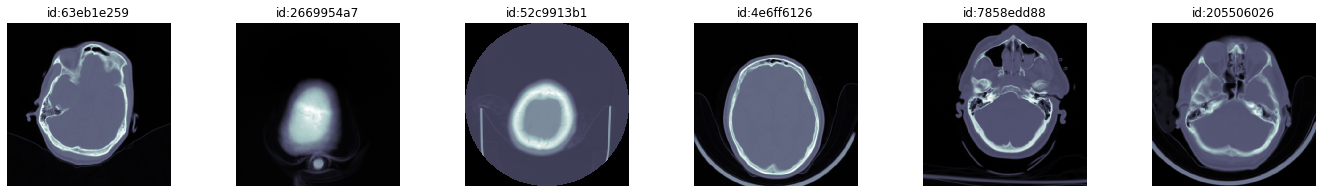

In [21]:
### using the pydicom module to get the pixel data
def load_image(ID,
               folder='/media/DATA/rsna-intracranial-hemorrhage-detection'):
    ds = pydicom.dcmread(os.path.join(folder, 'ID_%s.dcm' % ID))
    return ds.pixel_array

fig, AX = mg.figure(axes=(1,6), top=3.)
for i, ax in enumerate(AX)    :
    mg.image(load_image(DF_train['ID'][12+i]), cmap=mg.bone, ax=ax, title='id:'+DF_train['ID'][i])

# Exploring the dataset

## Frequencies of Hemorraghies

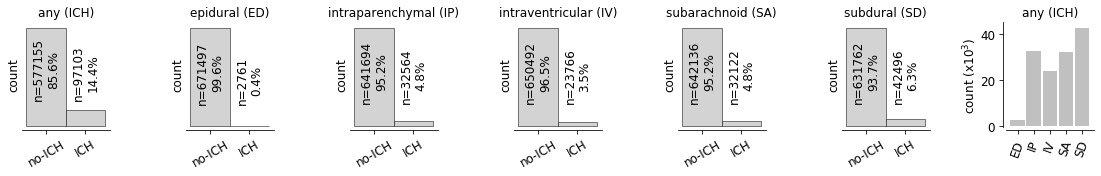

In [97]:
LOCS = ['epidural','intraparenchymal','intraventricular','subarachnoid','subdural']
A_LOCS = ['ED','IP','IV','SA','SD']

fig, AX = mg.figure(axes=(1,7), figsize=(.7,.7), wspace=4.)
for ax, label, abrv in zip(AX,
                           ['any']+LOCS,
                           ['ICH']+A_LOCS):
    mg.hist(DF_train[label], bins=[-.5,.5,1.5],
            axes_args=dict(spines=['bottom'], xticks=[0,1], xticks_labels=['no-ICH', 'ICH'], xticks_rotation=30),
            ax=ax, title='%s (%s)' % (label, abrv), lw=0.5)
    mg.annotate(ax, 'n=%i\n%.1f%%' % (np.sum(DF_train[label]==0),100.*np.sum(DF_train[label]==0)/len(DF_train[label])),
                (0,150000), xycoords='data', rotation=90, va='bottom', ha='center')
    mg.annotate(ax, 'n=%i\n%.1f%%' % (np.sum(DF_train[label]==1),100.*np.sum(DF_train[label]==1)/len(DF_train[label])),
                (1,150000), xycoords='data', rotation=90, va='bottom', ha='center')
    
mg.bar(np.array([np.sum(DF_train[label])/1e3 for label in LOCS]), ax=AX[6], ylabel='count (x10$^3$)',
       title='any (ICH)',
        axes_args=dict(xticks=range(len(A_LOCS)),xticks_labels=A_LOCS, xticks_rotation=70));

## Repartition of the different cases

ICH can span a single area among those considered, or can be a joint event of hemorhaggies in several areas.

Let's analyze the distribution of those cases.

In [23]:
# need to consider all subset combinations, we use the itertools module of python
LOCS = ['epidural','intraparenchymal','intraventricular','subarachnoid','subdural']
A_LOCS = ['ED','IP','IV','SA','SD']

from itertools import chain, combinations
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1,len(s)+1))

Case_ID = np.zeros(len(DF_train['any'])) # switched to True when counted by a case

# we need to start from the most
case_index, CASES_COUNT, CASE_nICH, ABREV = 1, [], [], []
for loc_list, abrev_list in zip(list(powerset(LOCS))[::-1], list(powerset(A_LOCS))[::-1]):
    # iterate 
    truth_condition = np.ones(len(DF_train['any']), dtype=bool) # True to start 
    for loc in loc_list:
        truth_condition = truth_condition & (DF_train[loc]==1) # each joint condition must be matched
    
    # need also not to have been included in a previous (more spread ICH) case
    truth_condition = truth_condition & (Case_ID==0)
    
    # then we set those cases to thei ID
    Case_ID[truth_condition] = case_index 
    CASE_nICH.append(len(loc_list))
    CASES_COUNT.append(np.sum(truth_condition))
    ABREV.append('-'.join(abrev_list))
    case_index += 1 
    
nICH = np.sum(DF_train['any']==1) # number of ICH cases
percentages = np.array(CASES_COUNT)*100./nICH

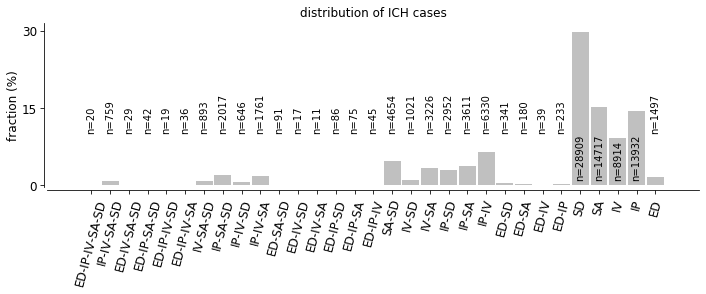

In [24]:
# a complete view of the different cases
percentage = np.array(CASES_COUNT)*100./nICH
ax = mg.bar(percentage, yerr=0., ylabel='fraction (%)',
       axes_args=dict(xticks=range(len(ABREV)), xticks_labels=ABREV, xticks_rotation=75),
       title='distribution of ICH cases', fig_args=dict(figsize=(3,1)))
for i, n in enumerate(CASES_COUNT):
    if n<8000:
        mg.annotate(ax, 'n=%i' % n, (i,10), xycoords='data', rotation=90, ha='center')
    else:
        mg.annotate(ax, 'n=%i' % n, (i,1), xycoords='data', rotation=90, ha='center')

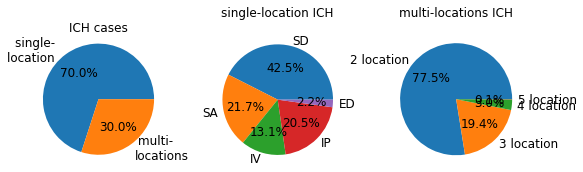

In [77]:
# single ICH source vs multiple sources

fig, AX = mg.figure(axes=(1,3), figsize=(.8,.8))
mg.pie([np.sum(percentages[np.array(CASE_nICH)==1]), np.sum(percentages[np.array(CASE_nICH)>1])],
        LABELS=['single-  \nlocation  ', ' multi-\nlocations'],
        title='ICH cases', ax=AX[0], COLORS=['b', 'lightgray'])
mg.pie([p for p in percentages[np.array(CASE_nICH)==1]],
         LABELS=A_LOCS[::-1],
        title='single-location ICH\n', ax=AX[1])
mg.pie([np.sum(percentages[np.array(CASE_nICH)==ii]) for ii in range(2,6)],
            LABELS=['%i location' % ii for ii in range(2,6)],
           title='multi-locations ICH\n', ax=AX[2])
#print(np.argwhere(percentages==))

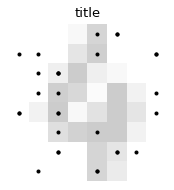

In [65]:
%run graphs/my_graph.py
mg = graphs('notebook')

need to set up labels


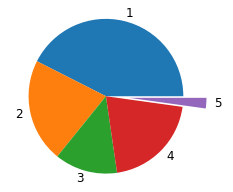

In [60]:
mg.pie([p for p in percentages[np.array(CASE_nICH)==1]],
        EXPLODES=[0,0,0,0,0.3], LABELS=[], autopct='')


### Co-occurence

In [36]:
np.unique(Case_ID)

array([0.])

### Computer Tomography data (DT scan)

In [60]:
### Computer Tomography data (DT scan)
fn = "/media/DATA/rsna-intracranial-hemorrhage-detection/ID_%s.dcm" % DF['ID'][20]
ds = pydicom.dcmread(fn)
print(ds)

(0008, 0018) SOP Instance UID                    UI: ID_b2ba0706d
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_6b257d60'
(0020, 000d) Study Instance UID                  UI: ID_b574dc579f
(0020, 000e) Series Instance UID                 UI: ID_d5bea7a164
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: ['-125.000000', '-85.797981', '-38.765362']
(0020, 0037) Image Orientation (Patient)         DS: ['1.000000', '0.000000', '0.000000', '0.000000', '0.927184', '-0.374607']
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 512
(0028, 0011) Columns                             US: 512
(0028, 0030) Pixel Spacing                       DS: ['0.488281', '0.488281']
(0028, 0100) Bits Allocated                      US: 16
(0028, 0101) Bits Stored 

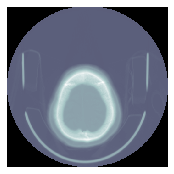

In [49]:
### Computer Tomography data (DT scan)
fn = "/media/DATA/rsna-intracranial-hemorrhage-detection/ID_%s.dcm" % DF['ID'][20]
ds = pydicom.dcmread(fn)
print(ds)
import matplotlib.pylab as plt
mg.bone = plt.cm.bone
def load_and_show_image(ID,
                        folder='/media/DATA/rsna-intracranial-hemorrhage-detection'):
    ds = pydicom.dcmread('data/ID_%s.dcm' % ID)
    mg.image(ds.pixel_array, cmap=mg.bone)


In [66]:
ds.WindowCenter

"30"

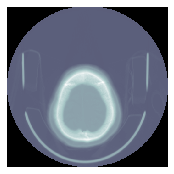

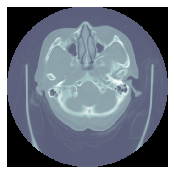

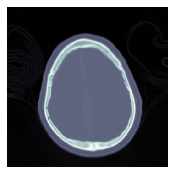

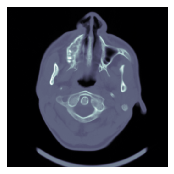

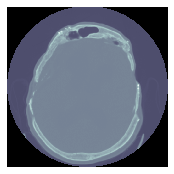

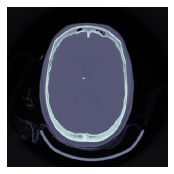

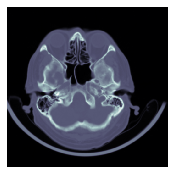

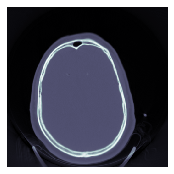

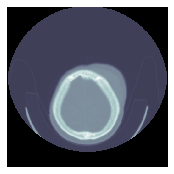

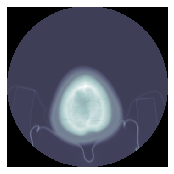

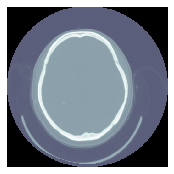

In [50]:
folder_entries = ['0a0a153e5','0a0aaeade', '0a0afe712', '0a0a4ff97',
     '0a0aaf9f1', '0a0a9133e','0a0abef61', '0a0a9691a','0a0ad4532',
     '0a0a9a8ef','0a0ae315e']
for f in folder_entries:
    load_and_show_image(f)

In [80]:
list(DF.keys())

['ID',
 'any',
 'epidural',
 'intraparenchymal',
 'intraventricular',
 'subarachnoid',
 'subdural']

In [ ]:
data = dict(np.load('data/summary_stage_1_train.npz'))
for fe in folder_entries:
    print(data[fe])

(0008, 0018) SOP Instance UID                    UI: ID_0a0afe712
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_1d580c01'
(0020, 000d) Study Instance UID                  UI: ID_c33e8e0e6d
(0020, 000e) Series Instance UID                 UI: ID_4488bf15c2
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: ['-118', '1.35887748', '319.788684']
(0020, 0037) Image Orientation (Patient)         DS: ['1', '0', '0', '0', '0.987688341', '-0.156434465']
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 512
(0028, 0011) Columns                             US: 512
(0028, 0030) Pixel Spacing                       DS: ['0.50390625', '0.50390625']
(0028, 0100) Bits Allocated                      US: 16
(0028, 0101) Bits Stored                         U

In [52]:
import matplotlib.pylab as plt
plt.figure(figsize=(25,25))
plt.imshow(ds.pixel_array, cmap=plt.cm.bone)

NameError: name 'ds' is not defined

<Figure size 1800x1800 with 0 Axes>

In [54]:
ds.pixel_array.shape

(512, 512)


As a starting

https://rd.springer.com/content/pdf/10.1007%2Fs00330-019-06163-2.pdf
